# CMPE 258 Assignment 4 Part 1
# Abhishek Bais

## Tasks :
a) Mini batch gradient descent along with appropriate learning rate.  
b) Dropout, initialize the random weights of network properly.  
c) Basic image augmentations to supplement the training data.  
d) Should use  3 or more layers for training (not 2 as in example ).  
e) Should use relu activation layer in right places like python code.  
f) Should normalize the input before training (scaling the input).  
g) Should use appropriate learning rate.  
h) Should provide appropriate metrics, visualization.    
i) Should display top common errors like in below link.  






# Load MNIST Dataset 


In [225]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [227]:
# Read in the Mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Visualize the dataset

In [228]:
# View the data
def visualize_N_elems_of_dataset(dataset, N, name):
  print("Visualizing the " + name + " dataset.")
  fig = plt.figure(figsize=plt.figaspect(0.3))

  # Plot N elems of the dataset
  for image in range(0, N):
    ax = fig.add_subplot(1, 10, image+1)
    ax.imshow(dataset[image], cmap='Accent')

Visualizing the train dataset.


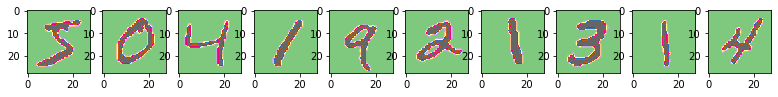

In [229]:
N = 10
visualize_N_elems_of_dataset(X_train, N, "train")

Visualizing the test dataset.


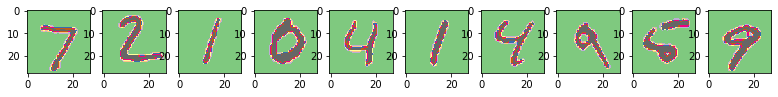

In [230]:
N = 10
visualize_N_elems_of_dataset(X_test, N, "test")

# Normalize the input, train/test split

In [231]:
from sklearn.model_selection import train_test_split
X_train, y_train = X_train / 255., y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
X_train, X_valid = X_train.reshape([X_train.shape[0], -1]), X_valid.reshape([X_valid.shape[0], -1])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54000, 784)
(10000, 28, 28)
(54000,)
(10000,)


# Define a loss function

Softmax cross entropy loss

In [232]:
# Crossentropy
def softmax_cross_entropy(logits, label):
    return - (logits[np.arange(len(logits)), label]) + np.log(np.sum(np.exp(logits), axis=-1))

# Gradient
def softmax_cross_entropy_grad(logits, label):
    one_hot = np.zeros_like(logits)
    one_hot[np.arange(len(logits)), label] = 1
    return (-one_hot + (np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True))) / logits.shape[0]

# Define Base Layer

In [233]:
# Use this as base interface to build dense layer on
class Layer:
  def __init__(self):
    pass

  def forward(self, x):
    return x
    
  def backward(self, x, outer_gradient):
    pass


# Define Dense Layers with random weights

In [234]:
# Dense Layer
class DenseLayer(Layer):
  # Init
  def __init__(self, ni, no, lr):
    super().__init__()
    
    # Init
    self.weights = np.random.randn(ni, no) * 0.01
    self.bias = np.zeros(no)
    self.lr = lr
    self.ni = ni
    self.no = no
    
  # Forward propagate input, output
  def forward(self, x):
     return np.dot(x, self.weights) + self.bias

  # Backprop gradient
  def backward(self, x, outer_gradient):
    # Gradient of x wrt weights, bias, loss  
    djDX = np.dot(outer_gradient, self.weights.T)

    # Gradient wrt to weights, bias
    djDW = x.T @ outer_gradient
    djDB = outer_gradient.mean(axis=0) * x.shape[0]
    
    # update weights, bias
    self.weights = self.weights - self.lr * djDW
    self.bias = self.bias - self.lr * djDB
    return djDX

  def __str__(self):
    return'Dense'

# Define ReLu Layer

In [235]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return np.maximum(0, x)

    def backward(self, x, outer_gradient):
        return outer_gradient * (x > 0)
    
    def __str__(self):
      return'Relu'

# Define Dropout layer

In [236]:
# Dropout layer with backprop, dropout
class DropoutLayer(Layer):
  # Init
  def __init__(self, ni, no, lr):
    super().__init__()
    
    # Init
    # xavier weight init
    variance = np.sqrt(2.0/(ni + no)) 
    self.weights = variance * np.random.randn(ni, no)
    self.bias = np.zeros(no)
    
    self.lr = lr
    self.ni = ni
    self.no = no
    
  # Forward propagate input, output
  def forward(self, x):
    return  (x@self.weights) + self.bias

  # Backprop gradient
  def backward(self, x, outer_gradient):
    # Gradient of x wrt weights, bias, loss  
    djDX = np.dot(outer_gradient, self.weights.T)

    # Gradient wrt to weights, bias
    djDW = np.transpose(outer_gradient.T @ x)
    djDB = np.mean(outer_gradient, axis=0)

    # drop out
    dropout = lambda x: x if np.random.rand() > 0.3 else 0 
    vdrop = np.vectorize(dropout)
    djDW = vdrop(djDW)*(1/(0.7))
    
    # update weights, bias
    self.weights = self.weights - self.lr * djDW
    self.bias = self.bias - self.lr * djDB
    return djDX

  def __str__(self):
    return'Dropout'

# Build the nueral net



In [237]:
# Build the NueralNet
def build_nueralNet(X, lr, add_dropout):
  NueralNet = []
  NueralNet.append(DenseLayer(X.shape[1], 100, lr))
  NueralNet.append(ReLU())
  
  # add drop out layers on request
  if (add_dropout):
    NueralNet.append(DropoutLayer(100,200,lr))
    NueralNet.append(DenseLayer(200, 100, lr))

  NueralNet.append(DenseLayer(100, 200, lr))
  NueralNet.append(ReLU())
  NueralNet.append(DenseLayer(200, 10, lr))
  return NueralNet

# Dump NueralNet
def dump(nueralNet):
  print('Builiding NueralNet:')
  for j, layer in enumerate(nueralNet):
    print('---- Layer {} ----'.format(j))
    print(layer)

# Forward propagate
def forward(nueralNet, X):
    layers = []
    for layer in nueralNet:
        X = layer.forward(X)
        layers.append(X)
    return layers

# Predict
def predict(nueralNet, X):
    return forward(nueralNet, X)[-1].argmax(axis=-1)

# Fit
def fit(nueralNet, X, y):
    layers = forward(nueralNet, X)
    inputs = [X] + layers
    logits = layers[-1]

    loss = softmax_cross_entropy(logits, y)
    loss_gradient = softmax_cross_entropy_grad(logits, y)
    
    for i in range(len(nueralNet))[::-1]:
        loss_gradient = nueralNet[i].backward(inputs[i], loss_gradient)
    return np.mean(loss)

# Define the hyper parameters

In [238]:
num_epochs = 25
lr = 0.1
batch_size = 32

# Define the mini batch to train

In [239]:
from tqdm.notebook import tqdm
def do_mini_batch(inputs, targets, batchsize, shuffle=False):
  if shuffle:
    indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
      if shuffle:
        excerpt = indices[start_idx:start_idx + batchsize]
      else:
        excerpt = slice(start_idx, start_idx + batchsize)
      yield inputs[excerpt], targets[excerpt]

# Fit, Predict without drop out

In [240]:
# Build Nueral Net
nn = build_nueralNet(X_train, lr, add_dropout=False)

# Dump the NueralNet layers
dump(nn)

Builiding NueralNet:
---- Layer 0 ----
Dense
---- Layer 1 ----
Relu
---- Layer 2 ----
Dense
---- Layer 3 ----
Relu
---- Layer 4 ----
Dense


In [241]:
# Fit, predict
train_log = []
valid_log = []
for epoch in range(1, num_epochs + 1):
    for x_batch, y_batch in do_mini_batch(X_train, y_train, batch_size, shuffle=True):
        fit(nn, x_batch, y_batch)
    pred_train = predict(nn, X_train)
    pred_valid = predict(nn, X_valid)

    train_log.append(np.mean(pred_train == y_train))
    valid_log.append(np.mean(pred_valid == y_valid))
    
    print("Epoch:", epoch, "of ", num_epochs)
    print("Train Accuracy:", train_log[-1])
    print("Valid Accuracy:", valid_log[-1])


Epoch: 1 of  25
Train Accuracy: 0.9356666666666666
Valid Accuracy: 0.9335



Epoch: 2 of  25
Train Accuracy: 0.9572222222222222
Valid Accuracy: 0.9508333333333333



Epoch: 3 of  25
Train Accuracy: 0.972574074074074
Valid Accuracy: 0.9655



Epoch: 4 of  25
Train Accuracy: 0.9769444444444444
Valid Accuracy: 0.9676666666666667



Epoch: 5 of  25
Train Accuracy: 0.9828703703703704
Valid Accuracy: 0.9701666666666666



Epoch: 6 of  25
Train Accuracy: 0.9877592592592592
Valid Accuracy: 0.9745



Epoch: 7 of  25
Train Accuracy: 0.9887407407407407
Valid Accuracy: 0.9738333333333333



Epoch: 8 of  25
Train Accuracy: 0.9890555555555556
Valid Accuracy: 0.9728333333333333



Epoch: 9 of  25
Train Accuracy: 0.9912962962962963
Valid Accuracy: 0.9735



Epoch: 10 of  25
Train Accuracy: 0.9878518518518519
Valid Accuracy: 0.9726666666666667



Epoch: 11 of  25
Train Accuracy: 0.9956111111111111
Valid Accuracy: 0.976



Epoch: 12 of  25
Train Accuracy: 0.9964259259259259
Valid Accuracy: 0.9786666666666667



Epoch: 13 of  25
Train Accuracy: 0.9966481481481482
Valid Accuracy: 0.978



Epoch: 14 of  25
Train Accuracy: 0.9969814814814815
Valid Accuracy: 0.9786666666666667



Epoch: 15 of  25
Train Accuracy: 0.9966296296296296
Valid Accuracy: 0.975



Epoch: 16 of  25
Train Accuracy: 0.9970555555555556
Valid Accuracy: 0.9773333333333334



Epoch: 17 of  25
Train Accuracy: 0.9967222222222222
Valid Accuracy: 0.9776666666666667



Epoch: 18 of  25
Train Accuracy: 0.9989629629629629
Valid Accuracy: 0.9776666666666667



Epoch: 19 of  25
Train Accuracy: 0.9997962962962963
Valid Accuracy: 0.9798333333333333



Epoch: 20 of  25
Train Accuracy: 0.9995555555555555
Valid Accuracy: 0.979



Epoch: 21 of  25
Train Accuracy: 0.9998148148148148
Valid Accuracy: 0.979



Epoch: 22 of  25
Train Accuracy: 0.9998703703703704
Valid Accuracy: 0.9795



Epoch: 23 of  25
Train Accuracy: 1.0
Valid Accuracy: 0.9806666666666667



Epoch: 24 of  25
Train Accuracy: 1.0
Valid Accuracy: 0.9803333333333333



Epoch: 25 of  25
Train Accuracy: 1.0
Valid Accuracy: 0.9801666666666666


# Visualize accuracy of prediction

Epoch 25
Training accuracy: 1.0
Validation accuracy: 0.9801666666666666


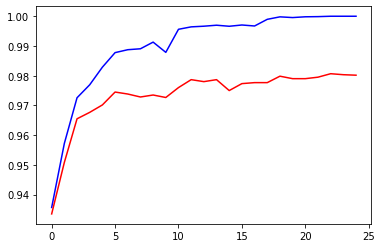

In [242]:
# Plot the accuracy metrics
print("Epoch",epoch)
print("Training accuracy:",train_log[-1])
print("Validation accuracy:",valid_log[-1])

# Plot
plt.plot(train_log, 'b', label='training accuracy')
plt.plot(valid_log, 'r', label='validation accuracy')
plt.show()   

# Plot the confusion matrix

In [243]:
# visualize accuracy on confusion matrix
def plot_confusion_matrix(y_true, y_pred):
  c_matrix = confusion_matrix(y_true, y_pred) 
  plt.imshow(c_matrix, cmap='Accent')
  
  for i, j in itertools.product(
      range(c_matrix.shape[0]), range(c_matrix.shape[1])):
      plt.text(j, i
               , c_matrix[i, j]
               , horizontalalignment="center"
               , color="white" if c_matrix[i, j] > (c_matrix.max() / 2.) else "black")

  plt.title('Confusion matrix plot')
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')


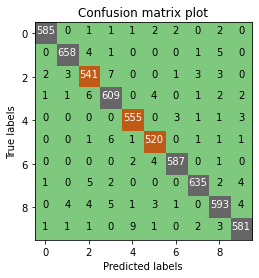

In [178]:
plot_confusion_matrix(y_valid, pred_valid)

# Build NueralNet with Dropout Layer

In [245]:
# Build Nueral Net
nn_with_do = build_nueralNet(X_train, lr, add_dropout=True)

# Dump the NueralNet layers
dump(nn_with_do)

Builiding NueralNet:
---- Layer 0 ----
Dense
---- Layer 1 ----
Relu
---- Layer 2 ----
Dropout
---- Layer 3 ----
Dense
---- Layer 4 ----
Dense
---- Layer 5 ----
Relu
---- Layer 6 ----
Dense


# Fit, Predict with dropout

In [247]:
# Fit, predict
train_log = []
valid_log = []
for epoch in range (num_epochs):
    for x_batch, y_batch in do_mini_batch(X_train, y_train, batch_size, shuffle=True):
        fit(nn_with_do, x_batch, y_batch)
    pred_train = predict(nn_with_do, X_train)
    pred_valid = predict(nn_with_do, X_valid)

    train_log.append(np.mean(pred_train == y_train))
    valid_log.append(np.mean(pred_valid == y_valid))
    
    print("Epoch:", epoch, "of ", num_epochs)
    print("Train Accuracy:", train_log[-1])
    print("Valid Accuracy:", valid_log[-1])


Epoch: 0 of  25
Train Accuracy: 0.8675555555555555
Valid Accuracy: 0.8571666666666666



Epoch: 1 of  25
Train Accuracy: 0.9554074074074074
Valid Accuracy: 0.9491666666666667



Epoch: 2 of  25
Train Accuracy: 0.9651296296296297
Valid Accuracy: 0.9571666666666667



Epoch: 3 of  25
Train Accuracy: 0.9617777777777777
Valid Accuracy: 0.9538333333333333



Epoch: 4 of  25
Train Accuracy: 0.9801296296296297
Valid Accuracy: 0.9655



Epoch: 5 of  25
Train Accuracy: 0.981037037037037
Valid Accuracy: 0.9716666666666667



Epoch: 6 of  25
Train Accuracy: 0.9854259259259259
Valid Accuracy: 0.9735



Epoch: 7 of  25
Train Accuracy: 0.9873888888888889
Valid Accuracy: 0.9743333333333334



Epoch: 8 of  25
Train Accuracy: 0.9875925925925926
Valid Accuracy: 0.972



Epoch: 9 of  25
Train Accuracy: 0.9913703703703703
Valid Accuracy: 0.972



Epoch: 10 of  25
Train Accuracy: 0.9922407407407408
Valid Accuracy: 0.975



Epoch: 11 of  25
Train Accuracy: 0.9931851851851852
Valid Accuracy: 0.974



Epoch: 12 of  25
Train Accuracy: 0.9903888888888889
Valid Accuracy: 0.9708333333333333



Epoch: 13 of  25
Train Accuracy: 0.9848888888888889
Valid Accuracy: 0.9665



Epoch: 14 of  25
Train Accuracy: 0.9931296296296296
Valid Accuracy: 0.9708333333333333



Epoch: 15 of  25
Train Accuracy: 0.9931111111111111
Valid Accuracy: 0.9755



Epoch: 16 of  25
Train Accuracy: 0.9938703703703704
Valid Accuracy: 0.9728333333333333



Epoch: 17 of  25
Train Accuracy: 0.9951666666666666
Valid Accuracy: 0.9751666666666666



Epoch: 18 of  25
Train Accuracy: 0.9936296296296296
Valid Accuracy: 0.9726666666666667



Epoch: 19 of  25
Train Accuracy: 0.9962777777777778
Valid Accuracy: 0.9756666666666667



Epoch: 20 of  25
Train Accuracy: 0.9945555555555555
Valid Accuracy: 0.974



Epoch: 21 of  25
Train Accuracy: 0.9947592592592592
Valid Accuracy: 0.9718333333333333



Epoch: 22 of  25
Train Accuracy: 0.9961111111111111
Valid Accuracy: 0.9746666666666667



Epoch: 23 of  25
Train Accuracy: 0.9943703703703703
Valid Accuracy: 0.9703333333333334



Epoch: 24 of  25
Train Accuracy: 0.9963333333333333
Valid Accuracy: 0.9783333333333334


# Visualize accuracy of prediction

Epoch 24
Training accuracy: 0.9963333333333333
Validation accuracy: 0.9783333333333334


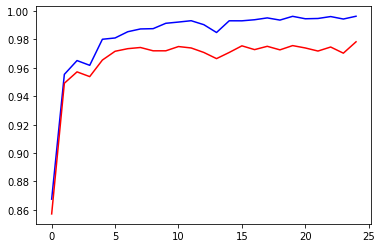

In [248]:
# Plot the accuracy metrics
print("Epoch",epoch)
print("Training accuracy:",train_log[-1])
print("Validation accuracy:",valid_log[-1])

# Plot
plt.plot(train_log, 'b', label='training accuracy')
plt.plot(valid_log, 'r', label='validation accuracy')
plt.show()  

# Plot confusion matrix

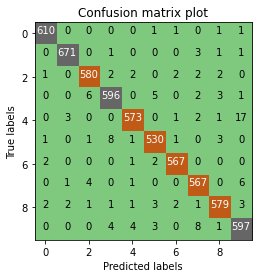

In [249]:
plot_confusion_matrix(y_valid, pred_valid)

# Augment images
## Reference used for underneath code
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [256]:
# Reload mnist dataset, augment images
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

gen.fit(X_train)

# Normalize the data

In [257]:
# Normalize the data
from sklearn.model_selection import train_test_split
X_train, y_train = X_train / 255., y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
X_train, X_valid = X_train.reshape([X_train.shape[0], -1]), X_valid.reshape([X_valid.shape[0], -1])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54000, 784)
(10000, 28, 28, 1)
(54000,)
(10000,)


# Fit, predict with augmnetation, dropout

In [258]:
# Fit, predict
train_log = []
valid_log = []
for epoch in range(1, num_epochs + 1):
    for x_batch, y_batch in do_mini_batch(X_train, y_train, batch_size, shuffle=True):
        fit(nn_with_do, x_batch, y_batch)
    pred_train = predict(nn_with_do, X_train)
    pred_valid = predict(nn_with_do, X_valid)

    train_log.append(np.mean(pred_train == y_train))
    valid_log.append(np.mean(pred_valid == y_valid))
    
    print("Epoch:", epoch, "of ", num_epochs)
    print("Train Accuracy:", train_log[-1])
    print("Valid Accuracy:", valid_log[-1])


Epoch: 1 of  25
Train Accuracy: 0.9938518518518519
Valid Accuracy: 0.9908333333333333



Epoch: 2 of  25
Train Accuracy: 0.9963148148148148
Valid Accuracy: 0.9935



Epoch: 3 of  25
Train Accuracy: 0.9975185185185185
Valid Accuracy: 0.9943333333333333



Epoch: 4 of  25
Train Accuracy: 0.998
Valid Accuracy: 0.9933333333333333



Epoch: 5 of  25
Train Accuracy: 0.9915
Valid Accuracy: 0.986



Epoch: 6 of  25
Train Accuracy: 0.9985185185185185
Valid Accuracy: 0.9926666666666667



Epoch: 7 of  25
Train Accuracy: 0.9971666666666666
Valid Accuracy: 0.9923333333333333



Epoch: 8 of  25
Train Accuracy: 0.9926481481481482
Valid Accuracy: 0.9876666666666667



Epoch: 9 of  25
Train Accuracy: 0.9979629629629629
Valid Accuracy: 0.9911666666666666



Epoch: 10 of  25
Train Accuracy: 0.9882222222222222
Valid Accuracy: 0.9798333333333333



Epoch: 11 of  25
Train Accuracy: 0.9933148148148148
Valid Accuracy: 0.9836666666666667



Epoch: 12 of  25
Train Accuracy: 0.9961481481481481
Valid Accuracy: 0.9873333333333333



Epoch: 13 of  25
Train Accuracy: 0.9988518518518519
Valid Accuracy: 0.9903333333333333



Epoch: 14 of  25
Train Accuracy: 0.9989444444444444
Valid Accuracy: 0.9911666666666666



Epoch: 15 of  25
Train Accuracy: 0.9965740740740741
Valid Accuracy: 0.9885



Epoch: 16 of  25
Train Accuracy: 0.9982777777777778
Valid Accuracy: 0.9901666666666666



Epoch: 17 of  25
Train Accuracy: 0.9903888888888889
Valid Accuracy: 0.9805



Epoch: 18 of  25
Train Accuracy: 0.9991666666666666
Valid Accuracy: 0.9915



Epoch: 19 of  25
Train Accuracy: 0.992537037037037
Valid Accuracy: 0.9818333333333333



Epoch: 20 of  25
Train Accuracy: 0.9995
Valid Accuracy: 0.9898333333333333



Epoch: 21 of  25
Train Accuracy: 0.9999259259259259
Valid Accuracy: 0.9906666666666667



Epoch: 22 of  25
Train Accuracy: 0.9999814814814815
Valid Accuracy: 0.9915



Epoch: 23 of  25
Train Accuracy: 0.9999814814814815
Valid Accuracy: 0.9923333333333333



Epoch: 24 of  25
Train Accuracy: 0.9999814814814815
Valid Accuracy: 0.9923333333333333



Epoch: 25 of  25
Train Accuracy: 0.9999814814814815
Valid Accuracy: 0.9923333333333333


# Visualize accuracy of prediction

Epoch 25
Training accuracy: 0.9999814814814815
Validation accuracy: 0.9923333333333333


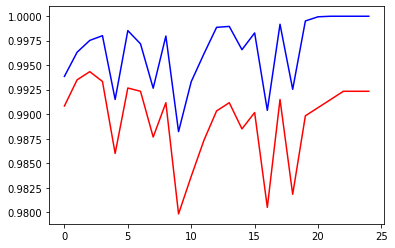

In [259]:
# Plot the accuracy metrics
print("Epoch",epoch)
print("Training accuracy:",train_log[-1])
print("Validation accuracy:",valid_log[-1])

# Plot
plt.plot(train_log, 'b', label='training accuracy')
plt.plot(valid_log, 'r', label='validation accuracy')
plt.show()   

# Plot confusion matrix

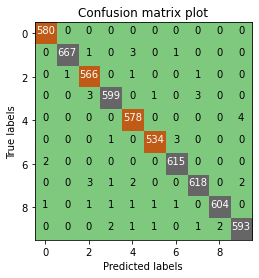

In [260]:
plot_confusion_matrix(y_valid, pred_valid)